# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic, and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer "buy 10 dollars get 2 off" on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10-day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a "buy 10 dollars get 2 dollars off" offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Data Sets

The data is contained in three files:

- `portfolio.json` - containing offer ids and meta data about each offer (duration, type, etc.)
- `profile.json` - demographic data for each customer
- `transcript.json` - records for transactions, offers received, offers viewed, and offers completed

### Here is the schema and explanation of each variable in the files:

#### `portfolio.json`

- `id` (string) - offer id
- `offer_type` (string) - type of offer i.e., BOGO, discount, informational
- `difficulty` (int) - minimum required spend to complete an offer
- `reward` (int) - reward given for completing an offer
- `duration` (int) - time for offer to be open, in days
- `channels` (list of strings)

#### `profile.json`

- `age` (int) - age of the customer
- `became_member_on` (int) - date when customer created an app account
- `gender` (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- `id` (str) - customer id
- `income` (float) - customer's income

#### `transcript.json`

- `event` (str) - record description (i.e., transaction, offer received, offer viewed, etc.)
- `person` (str) - customer id
- `time` (int) - time in hours since start of test. The data begins at time t=0
- `value` - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the `transcript.json` file correctly, but the newest version of pandas can. You can access the terminal from the orange icon in the top left of this notebook.

You can see how to access the terminal and how the install works using the two images below. First, you need to access the terminal:

Then you will want to run the above command:



## Capstone Project Objective

This dataset comprises simulated data that emulates customer interactions with the Starbucks rewards mobile application. Periodically, Starbucks dispatches various offers to app users. These offers range from simple advertisements for beverages to tangible promotions such as discounts or BOGO (buy one get one free) deals. It is noteworthy that some users may not receive any offers during certain weeks.

**The objective of this project is to integrate transaction, demographic, and offer data to ascertain which demographic segments exhibit the most favorable responses to specific types of offers. This dataset represents a streamlined version of the actual Starbucks app, as the underlying simulator is limited to a single product, whereas Starbucks' real-world inventory includes a diverse array of products.**

In [2]:
from importlib import reload
from tabulate import tabulate

import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



In [3]:
import working.print.printer as p


In [4]:
reload(p)

<module 'working.print.printer' from '/home/subhopam/Documents/Programming/Data_Science/starbucks_capstone/starbucks-capstone/working/print/printer.py'>

In [5]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

In [6]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [7]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


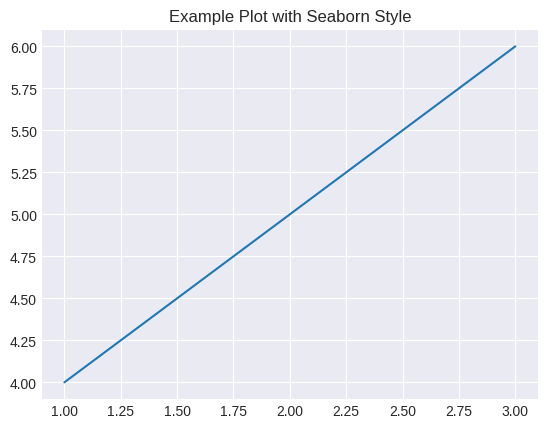

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style
plt.style.use('seaborn-v0_8-darkgrid')

# Example plot
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('Example Plot with Seaborn Style')
plt.show()

In [9]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['lines.linewidth'] = 2


font = {'family': 'serif',
        'color':  '#2E86C1',
        'weight': 'normal',
        'size': 20,
        }

base_color = sns.color_palette()[0]

In [10]:
from sklearn.metrics import confusion_matrix

## Import Datasets


In [11]:

# read in the json files
portfolio= pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [12]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [13]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [14]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


<b style="font-size:20px;">Assessing Data</b>

<b style="font-size:16px;">Profile</b>

In [15]:
print('---- check the type on columns in profile dataset  --')
profile.info()

---- check the type on columns in profile dataset  --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
print('---- check the null values in the profile dataset  --')
profile.isnull().sum()

---- check the null values in the profile dataset  --


gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [17]:
p.print_comment('check the age column')

# check the age column
print(profile.age.value_counts(), '\n')

p.print_comment('describe of age column')

# check the describe of age column
print(profile.age.describe(), '\n')

p.print_comment('check the age 118')

# check the age 118
x = profile[profile.age == 118]
print(x[:2])
x.age.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check the age column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
age
118    2175
58      408
53      372
51      363
59      359
       ... 
100      12
96        8
98        5
101       5
99        5
Name: count, Length: 85, dtype: int64 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ describe of age column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64 

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check the age 118 ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
  gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN


age
118    2175
Name: count, dtype: int64

In [18]:
# check income column
p.print_comment('describe of income column')
profile.income.describe()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ describe of income column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [19]:
# check duplicate
p.print_comment('check duplicate')
profile[profile.duplicated()]

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check duplicate ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


,gender,age,id,became_member_on,income


<b style="font-size:16px;">Portfolio</b>

In [20]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [21]:
# check columns type
p.print_comment('check columns type')

portfolio.info()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check columns type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [22]:
# check offer_type column

p.print_comment('check offer_type column')
portfolio.offer_type.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check offer_type column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

<b style="font-size:16px;">transcript</b>

In [23]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [24]:
# check column type
p.print_comment('check column type')
transcript.info()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check column type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [25]:
# check event column
p.print_comment('check event column')
transcript.event.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [26]:
# check time column
p.print_comment('check time column')
transcript.time.value_counts()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check time column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


time
408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: count, Length: 120, dtype: int64

In [27]:
# check value column
p.print_comment('check value column')
transcript.value

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

## Observations

### Profile Dataset
- `became_member_on`: Needs to be converted to a date format.
- `gender`: Contains 2,175 missing values.
- `income`: Contains 2,175 missing values.
- `age`: 2,175 entries have an age of 118 years, which appears to be an outlier. These entries also have missing values for gender and income.
- `id`: Rename to `customer_id`.
- `gender`: Requires encoding.
- `became_member_on`: Requires encoding.

### Portfolio Dataset
- `id`: Rename to `offer_id`.
- `channels`: Requires encoding.
- `offer_type`: Requires encoding.
- `offer_id`: Create a new column with offer names, such as `offer_1`.

### Transcript Dataset
- `time`: Convert to days.
- `person`: Rename to `customer_id`.
- `value`: Extract `offer_id` and `amount`.
- `event`: Requires encoding.

# Data Wrangling & Feature Enginnering

## profile

### 
**Define**: `became_member_on` not date

In [28]:
# check became_member_on column
p.print_comment('check became_member_on column')

print(profile.became_member_on.value_counts())

# Code: convert date string to date
p.print_comment('Code:convert date string to date')

profile['became_member_on'] =\
    pd.to_datetime(profile.became_member_on, format="%Y%m%d")
print('done')


# test : convert date string to date
p.print_comment('test:convert date string to date')
print(profile.became_member_on)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check became_member_on column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
became_member_on
20171207    43
20170819    42
20171007    40
20171113    39
20170815    38
            ..
20131203     1
20130826     1
20140615     1
20140408     1
20130923     1
Name: count, Length: 1716, dtype: int64
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Code:convert date string to date ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
done
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test:convert date string to date ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
0       2017-02-12
1       2017-07-15
2       2018-07-12
3       2017-05-09
4       2017-08-04
           ...    
16995   2018-06-04
16996   2018-07-13
16997   2017-01-26
16998   2016-03-07
16999   2017-07-22
Name: became_member_on, Length: 17000, dtype: datetime64[ns]


### 
**Define**: `age` there are $2175$ persons have 118 years it seem to be outlier. we can also notice that is located in same row with `gender` and `income` that have `NaN` value

**Define**: `gender`there are $2175$ Missing value

**Define**: `income`there are $2175$ Missing value

In [29]:
# code: drop nan value rows
p.print_comment('code: drop nan value rows')
profile.dropna(inplace=True)
profile.reset_index(drop=True, inplace=True)
p.print_done()

# test: 
p.print_comment('test:')
profile.isnull().sum()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: drop nan value rows ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

### 
**Define**: id change his name to customer_id

In [30]:
# check columns name
p.print_comment('check columns name')
print(profile.columns)


# code: change id name
try:
    p.print_comment('code: change id name')
    profile.rename(columns={"id": "customer_id"}, inplace=True)
except Exception as e: print(e)
else:
    p.print_done()


# test:
p.print_comment('test: columns name')
print(profile.columns)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: change id name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Index(['gender', 'age', 'customer_id', 'became_member_on', 'income'], dtype='object')


### 
**Define**: `gender` need to encode

In [31]:
profile.gender.value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

In [32]:
from sklearn.preprocessing import OneHotEncoder
"""
Encodes the 'gender' column in the 'profile' DataFrame using OneHotEncoder.
Parameters:
- profile (DataFrame): The DataFrame containing the 'gender' column to be encoded.
Returns:
- None
Raises:
- Exception: If an error occurs during the encoding process.


The OneHotEncoder from the sklearn.preprocessing module is used to convert categorical variables into a format that can be provided to machine learning algorithms to improve predictions. Specifically, it transforms categorical features into a one-hot numeric array.

How It Works:
Input: A column with categorical data (e.g., 'gender' with values 'Male', 'Female', 'Other').
Output: A binary matrix where each column represents one possible category value, and each row has a single '1' in the column corresponding to the category value for that row, with '0's in all other columns.
Example Usage:

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Sample data
data = {'gender': ['Male', 'Female', 'Other', 'Female']}
df = pd.DataFrame(data)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
encoded_data = encoder.fit_transform(df[['gender']])

# Convert the result to a DataFrame for better readability
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender']))

print(encoded_df)from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Sample data
data = {'gender': ['Male', 'Female', 'Other', 'Female']}
df = pd.DataFrame(data)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
encoded_data = encoder.fit_transform(df[['gender']])

# Convert the result to a DataFrame for better readability
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['gender']))

print(encoded_df)


"""

encoder = OneHotEncoder(sparse_output=False)

try:
    # code: encode gender column
    p.print_comment('code: encode gender column')
    onehot = encoder.fit_transform(profile[['gender']])
    print(onehot)

    profile[['Female', 'Male', 'other']] = onehot
    
except Exception as e:
    print(e)
else:
    p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: encode gender column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨


In [33]:
profile.head(2)

,gender,age,customer_id,became_member_on,income,Female,Male,other
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1.0,0.0,0.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1.0,0.0,0.0


### 
**Define**`become_member_on` need to encode

In [34]:
# code: encode become_member_on
p.print_comment('code: encode become_member_on')
try:
    profile['become_member_on_year'] = profile.became_member_on.dt.year.astype(str)
    profile['become_member_on_month'] = profile.became_member_on.dt.month.astype(str)
    profile['become_member_on_day'] = profile.became_member_on.dt.day.astype(str)
        # Example: Create a new feature for the length of membership
    profile['membership_length_in_days'] = (pd.to_datetime('today') - pd.to_datetime(profile.became_member_on)).dt.days
except Exception as e: print(e)
else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: encode become_member_on ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨


In [35]:
profile


,gender,age,customer_id,became_member_on,income,Female,Male,other,become_member_on_year,become_member_on_month,become_member_on_day,membership_length_in_days
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1.0,0.0,0.0,2017,7,15,2601
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1.0,0.0,0.0,2017,5,9,2668
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0.0,1.0,0.0,2018,4,26,2316
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0.0,1.0,0.0,2018,2,9,2392
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0.0,1.0,0.0,2017,11,11,2482
...,...,...,...,...,...,...,...,...,...,...,...,...
14820,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1.0,0.0,0.0,2018,6,4,2277
14821,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,0.0,1.0,0.0,2018,7,13,2238
14822,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,0.0,1.0,0.0,2017,1,26,2771
14823,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1.0,0.0,0.0,2016,3,7,3096


In [36]:
# drop become_member_on column
p.print_comment('drop become_member_on column')

profile.drop('became_member_on', axis=1, inplace=True)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ drop become_member_on column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


## portfolio 

### 
**Define**: `id` change his name to `offer_id`

In [37]:
# check columns name
p.print_comment('check columns name')
print(portfolio.columns)


# code: change id name
try:
    p.print_comment('code: change id name')
    portfolio.rename(columns={"id": "offer_id"}, inplace=True)
except Exception as e: print(e)
else:
    p.print_done()


# test:
p.print_comment('test: columns name')
print(portfolio.columns)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: change id name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type',
       'offer_id'],
      dtype='object')


### 
**Define**: `channels` need to encode

In [38]:
# check the type
p.print_comment('check the type')
type(portfolio.channels[0])

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check the type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


list

In [39]:
# return all channels
p.print_comment('return all channels')
try:
    print(portfolio.channels.value_counts())
except: pass

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ return all channels ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
channels
[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: count, dtype: int64


In [40]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [41]:
# code: split channels column
p.print_comment('code: split channels column')

def split_channels(channels_list, channel):
    """split channels to columns"""
    return 1 if channel in channels_list else 0

try:
    all_channels = ['web', 'email', 'mobile', 'social']
    for channel in all_channels:
        portfolio[channel] = portfolio.channels.apply(lambda x: split_channels(x, channel))
except:
    pass
else:
    p.print_done()

# test
p.print_comment('test: split channels column')
portfolio.head(2)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: split channels column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: split channels column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


,reward,channels,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [42]:
try:
    p.print_comment('Drop channels column')
    portfolio.drop('channels', axis=1, inplace=True)
except: pass
else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ Drop channels column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨


### 
**Define**: `offer_type` need to encode


In [43]:
# return all offer_type

p.print_comment('return all offer_type')
offer_type = portfolio.offer_type.unique()
offer_type

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ return all offer_type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


array(['bogo', 'informational', 'discount'], dtype=object)

In [44]:
portfolio.head(2)

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1


In [45]:
# code: split offer_type column
p.print_comment('code: split offer_type column')

def split_offer_type(val, offer):
    """split offer_type column"""
    return 1 if val == offer else 0

try:
    for offer in offer_type:
        portfolio[offer] = portfolio.offer_type.apply(lambda x: split_offer_type(x, offer))
except:
    pass
else:
    p.print_done()

# test
p.print_comment('test: split offer_type column')
portfolio.head(2)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: split offer_type column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: split offer_type column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0


### 
**Define** `offer_id` create column has offer name like offer_1

In [46]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,informational,discount
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,0,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,0,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,0,1


In [47]:
# code: create offer_name column
p.print_comment('code: create offer_name column')

try: 
    lst = range(1,portfolio.shape[0]+1)
    x = [f"offer_{x}" for x in lst]
    portfolio['offer_name'] = x

except: pass

else: 
    p.print_done()
    print(portfolio[['offer_id','offer_name']])


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: create offer_name column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
                           offer_id offer_name
0  ae264e3637204a6fb9bb56bc8210ddfd    offer_1
1  4d5c57ea9a6940dd891ad53e9dbe8da0    offer_2
2  3f207df678b143eea3cee63160fa8bed    offer_3
3  9b98b8c7a33c4b65b9aebfe6a799e6d9    offer_4
4  0b1e1539f2cc45b7b9fa7c272da2e1d7    offer_5
5  2298d6c36e964ae4a3e7e9706d1fb8c2    offer_6
6  fafdcd668e3743c1bb461111dcafc2a4    offer_7
7  5a8bc65990b245e5a138643cd4eb9837    offer_8
8  f19421c1d4aa40978ebb69ca19b0e20d    offer_9
9  2906b810c7d4411798c6938adc9daaa5   offer_10


## transcript

### 
**Define**: `time` convert to days

In [48]:
transcript.head(5)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [49]:
# check time column
p.print_comment('check time column')
print(transcript.time.value_counts().sort_index()[:5])

# check the type
p.print_comment('check the type')
print(type(transcript.time[0]))

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check time column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
time
0     15561
6      2506
12     2215
18     2015
24     1921
Name: count, dtype: int64
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check the type ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
<class 'numpy.int64'>


In [50]:
def convert_time_day(val):
    """convert from time to days"""
    return val / 24

try:
    # code: convert time to days
    p.print_comment('code: convert time to days')

    transcript['days'] = transcript.time.apply(convert_time_day)

except Exception as e: print(e)

else: p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: convert time to days ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨


In [51]:
# test: convert time to days
p.print_comment('test: convert time to days')

transcript.days[-10:]

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: convert time to days ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


306524    29.75
306525    29.75
306526    29.75
306527    29.75
306528    29.75
306529    29.75
306530    29.75
306531    29.75
306532    29.75
306533    29.75
Name: days, dtype: float64

### 
**Define**: `person` change his name to `customer_id`

In [52]:
# return columns name

p.print_comment('return columns name')
print(transcript.columns)

# code: change column name
try:
    p.print_comment('code: change column name')
    transcript.rename(columns={"person": "customer_id"}, inplace=True)
except: pass
else: p.print_done()
    
# test: change column name
p.print_comment('return columns name')
print(transcript.columns)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ return columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Index(['person', 'event', 'value', 'time', 'days'], dtype='object')
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: change column name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ return columns name ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Index(['customer_id', 'event', 'value', 'time', 'days'], dtype='object')


### 
**Define**: `value` extract `offer_id` and `amount`

In [53]:
# check value column
p.print_comment('check value column')
transcript.value

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [54]:
# return the keys in value column
p.print_comment('return the keys in value column')

keys = []
def get_keys(val):
    """return available keys"""
    if val is not None and isinstance(val, dict):
        if list(val.keys()) not in keys:
            keys.append(list(val.keys()))

transcript.value.apply(get_keys)

keys = [item for elem in keys for item in elem]
print(keys)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ return the keys in value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
['offer id', 'amount', 'offer_id', 'reward']


In [55]:
transcript.tail(10)

,customer_id,event,value,time,days
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,{'amount': 25.14},714,29.75
306525,eec70ab28af74a22a4aeb889c0317944,transaction,{'amount': 43.58},714,29.75
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714,29.75
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,29.75
306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,29.75
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,29.75
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,29.75
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29.75
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29.75
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,29.75


In [56]:
def split_key(val):
    """split key column"""
    if list(val.keys())[0].startswith(key[:2]):
        return list(val.values())[0]
    else:
        return 0
    
try:  
    # code: split value column
    p.print_comment('code: splite value column')
    
    for key in keys[1:3]:
        transcript[key] = transcript.value.apply(split_key)
except: pass

else: p.print_done()
    
# test: split value column
p.print_comment('test: splite value column')
transcript.tail(10)



▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: splite value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: splite value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


,customer_id,event,value,time,days,amount,offer_id
306524,d613ca9c59dd42f497bdbf6178da54a7,transaction,{'amount': 25.14},714,29.75,25.14,0
306525,eec70ab28af74a22a4aeb889c0317944,transaction,{'amount': 43.58},714,29.75,43.58,0
306526,24f56b5e1849462093931b164eb803b5,transaction,{'amount': 22.64},714,29.75,22.64,0
306527,24f56b5e1849462093931b164eb803b5,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,29.75,0.00,fafdcd668e3743c1bb461111dcafc2a4
306528,5ca2620962114246ab218fc648eb3934,transaction,{'amount': 2.2},714,29.75,2.20,0
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,29.75,1.59,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,29.75,9.53,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,29.75,3.61,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,29.75,3.53,0
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714,29.75,4.05,0


In [57]:
# drop value column
p.print_comment('drop value column')

transcript.drop('value', axis=1, inplace=True)

# test
p.print_comment('test')

transcript.columns

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ drop value column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


Index(['customer_id', 'event', 'time', 'days', 'amount', 'offer_id'], dtype='object')

### 
**Define**: `event` need to encode

In [58]:
# return unique value in event column
p.print_comment('return unique value in event column')

event_list = transcript.event.unique()
event_list

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ return unique value in event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [59]:
transcript.tail(50)

,customer_id,event,time,days,amount,offer_id
306484,a4c2dd694269444085976f10b9b225f6,transaction,714,29.75,28.58,0
306485,4b59509988d34c7298119a840c946453,transaction,714,29.75,0.06,0
306486,92153f7cdda8486b9a2214ceb11b1a17,transaction,714,29.75,4.39,0
306487,3c88696ac23741cb8a709d656fe5ccdf,transaction,714,29.75,25.76,0
306488,1b24e887d980450497b631d8756128e6,transaction,714,29.75,0.35,0
306489,1c71315203b746b786c43ce12d7e97fe,transaction,714,29.75,20.84,0
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,29.75,0.00,3f207df678b143eea3cee63160fa8bed
306491,693082e8ccf9458a88c428779cf556a6,transaction,714,29.75,2.16,0
306492,d4f6205a98b4420082aae16e5a93655a,transaction,714,29.75,1.22,0
306493,7b2939e61c324b2087328c4b6fee2632,transaction,714,29.75,26.41,0


In [60]:
def split_event(val):
    """split event column"""
    if val == event:
        return 1
    else:
        return 0

try:
    # code: split event column
    p.print_comment('code: split event column')
    
    for event in event_list:
        transcript[event] = transcript.event.apply(split_event)
except: pass
else: p.print_done()
    

# test: split event column
p.print_comment('test: split event column')

transcript.tail(50)

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ code: split event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: split event column ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


,customer_id,event,time,days,amount,offer_id,offer received,offer viewed,transaction,offer completed
306484,a4c2dd694269444085976f10b9b225f6,transaction,714,29.75,28.58,0,0,0,1,0
306485,4b59509988d34c7298119a840c946453,transaction,714,29.75,0.06,0,0,0,1,0
306486,92153f7cdda8486b9a2214ceb11b1a17,transaction,714,29.75,4.39,0,0,0,1,0
306487,3c88696ac23741cb8a709d656fe5ccdf,transaction,714,29.75,25.76,0,0,0,1,0
306488,1b24e887d980450497b631d8756128e6,transaction,714,29.75,0.35,0,0,0,1,0
306489,1c71315203b746b786c43ce12d7e97fe,transaction,714,29.75,20.84,0,0,0,1,0
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,29.75,0.00,3f207df678b143eea3cee63160fa8bed,0,1,0,0
306491,693082e8ccf9458a88c428779cf556a6,transaction,714,29.75,2.16,0,0,0,1,0
306492,d4f6205a98b4420082aae16e5a93655a,transaction,714,29.75,1.22,0,0,0,1,0
306493,7b2939e61c324b2087328c4b6fee2632,transaction,714,29.75,26.41,0,0,0,1,0


In [61]:
# rename columns
p.print_comment('rename columns')

transcript.rename(columns={ "offer received": "offer_received", 
                            "offer viewed": "offer_viewed",
                            "offer completed": "offer_completed"},
                 inplace=True)

# test: rename columns
p.print_comment('test: rename columns')
transcript.columns

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ rename columns ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ test: rename columns ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


Index(['customer_id', 'event', 'time', 'days', 'amount', 'offer_id',
       'offer_received', 'offer_viewed', 'transaction', 'offer_completed'],
      dtype='object')

## Create offer dataframe

create offer dataframe from people that have offers

In [62]:
# create offer dataframe 
offer = transcript[transcript.event != 'transaction']
offer.head()

,customer_id,event,time,days,amount,offer_id,offer_received,offer_viewed,transaction,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.0,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0


## Create successful offer column

**Note**: An offer is  successful only if a customer completed an offer and viewed it

In [63]:
# check if the offer is success or not

# Group-by value counts in event column 
offer_customer = offer.pivot_table(index=['customer_id','offer_id'],\
                 columns='event', aggfunc='size', fill_value=0)
offer_customer.reset_index(level=[0,1], inplace=True)

# create successful_offer column 
offer_customer['successful_offer'] =\
    offer_customer['offer completed'] * offer_customer['offer viewed']

offer_customer['successful_offer'] = offer_customer['successful_offer'].apply(lambda x: 1 if x > 0 else 0)

## Merge datasets
create overall dataset that a combination from offer_customer dataset and profile dataset and portoflio dataset

In [64]:
# merge dataset profile and portolio and offer_customer
overall_df = pd.merge(offer_customer,portfolio,on='offer_id', how='left')
overall_df = pd.merge(overall_df,profile,on='customer_id')
overall_df

,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer,reward,difficulty,duration,offer_type,...,gender,age,income,Female,Male,other,become_member_on_year,become_member_on_month,become_member_on_day,membership_length_in_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,2,10,7,discount,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,0,4,informational,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,0,3,informational,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,5,5,5,bogo,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,2,10,10,discount,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,1,5,5,5,bogo,...,M,34,34000.0,0.0,1.0,0.0,2017,1,23,2774
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,5,20,10,discount,...,F,45,62000.0,1.0,0.0,0.0,2016,11,25,2833
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,1,2,10,7,discount,...,F,45,62000.0,1.0,0.0,0.0,2016,11,25,2833
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,5,5,7,bogo,...,F,45,62000.0,1.0,0.0,0.0,2016,11,25,2833


# Export clean data

In [65]:
# export clean data
p.print_comment('export clean data')

profile.to_csv('clean_profile.csv', index=False)
portfolio.to_csv('clean_portfolio.csv', index=False)
transcript.to_csv('clean_transcript.csv', index=False)
overall_df.to_csv('overall_df.csv', index=False)

p.print_done()

▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ export clean data ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Celebration: your job completed ✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨


# Exploratory Data Analysis (EDA)

In [66]:
portfolio = pd.read_csv('clean_portfolio.csv')
profile = pd.read_csv('clean_profile.csv')
transcript = pd.read_csv('clean_transcript.csv')
overall_df = pd.read_csv('overall_df.csv')

## Profile

In [67]:
profile['become_member_on_month'] = profile.become_member_on_month.astype(str)
profile['become_member_on_year'] = profile.become_member_on_year.astype(str)
profile['become_member_on_day'] = profile.become_member_on_day.astype(str)
profile['membership_length_in_days'] = profile.membership_length_in_days.astype(str)

### Gender Distribution

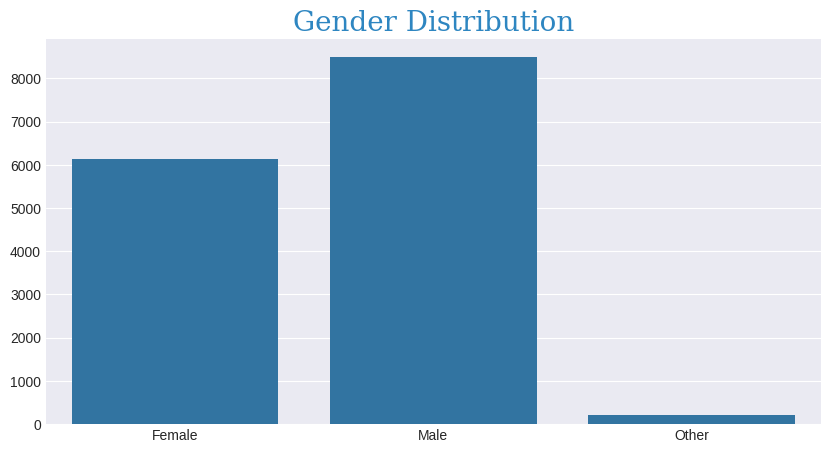

In [68]:
gender_count = [profile.Female.sum(), profile.Male.sum(), profile.other.sum()]
x_label = ['Female', 'Male', 'Other']
sns.barplot(y = gender_count, x = x_label , color=base_color);
plt.title('Gender Distribution', fontdict=font);


> we can notice that most of users are Male

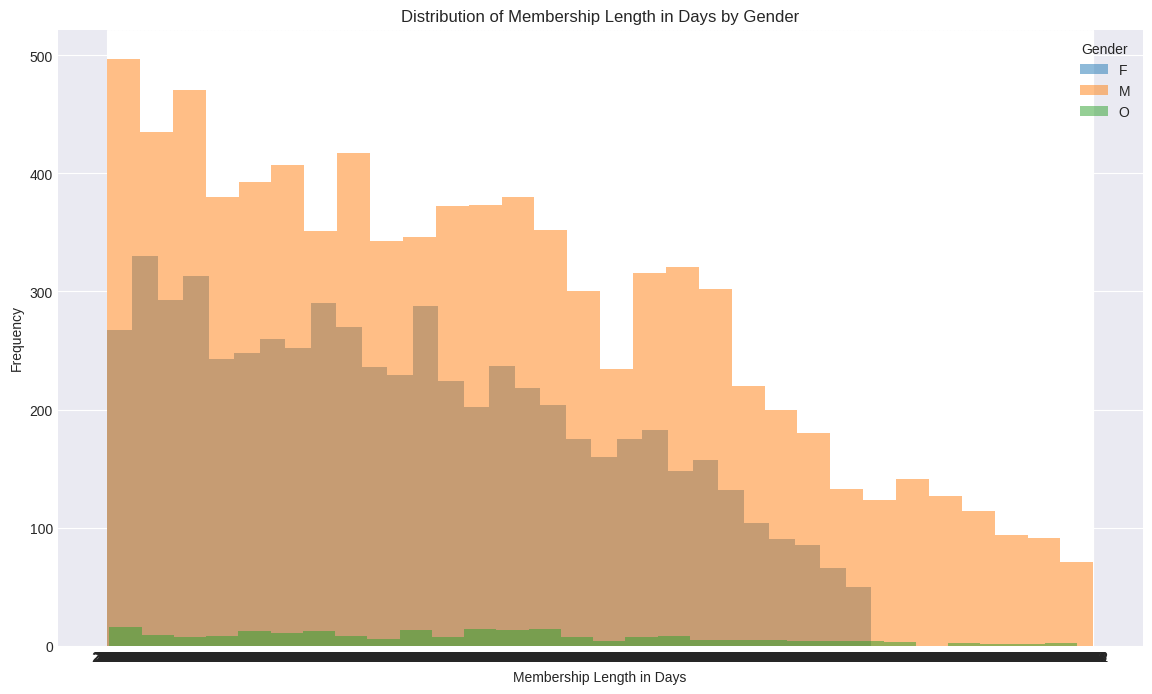

In [69]:
# Plot the distribution for each gender
genders = profile['gender'].unique()
plt.figure(figsize=(14, 8))

for gender in genders:
    subset = profile[profile['gender'] == gender]
    plt.hist(subset['membership_length_in_days'], bins=30, alpha=0.5, label=gender)

plt.title('Distribution of Membership Length in Days by Gender')
plt.xlabel('Membership Length in Days')
plt.ylabel('Frequency')
plt.legend(title='Gender')
plt.grid(True)
plt.show()

### Income Distribution

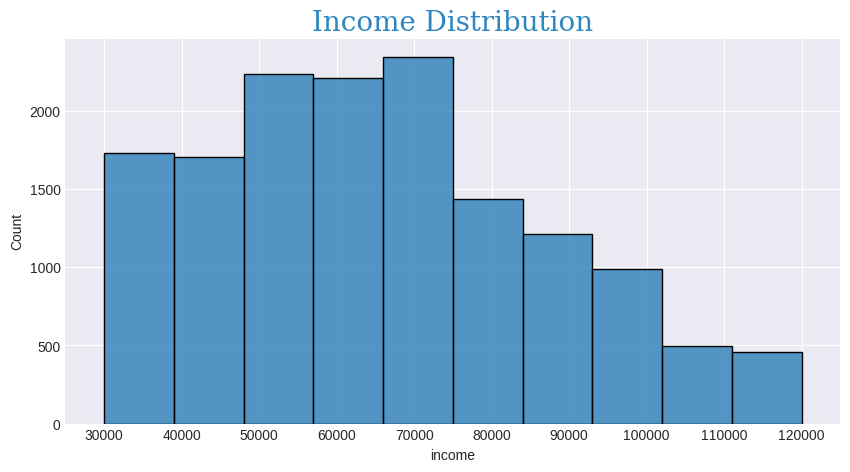

In [70]:
bin_edges = np.arange(0, profile['income'].max()+1, 10000)

sns.histplot(profile['income'],bins=10);
plt.xticks(bin_edges)
plt.xlim(profile.income.min()-5000, profile.income.max()+5000)
plt.title('Income Distribution', fontdict=font);

> We can notice that the most income between $50000 \to 70000$

### Age Distribution

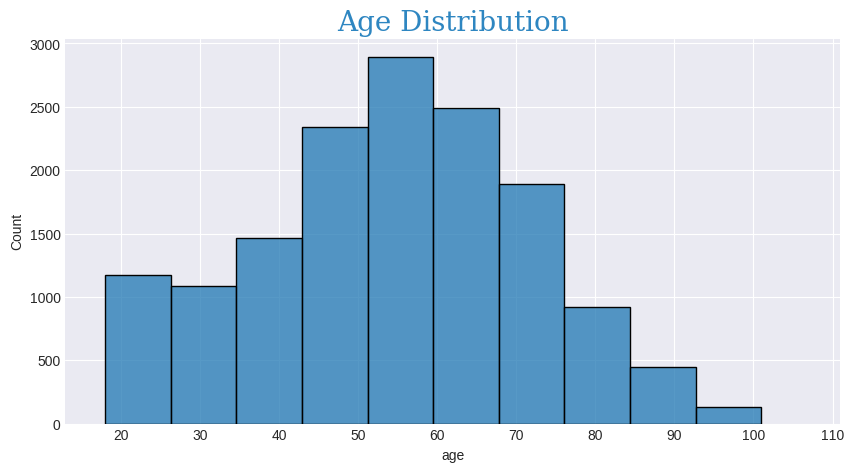

In [71]:
bin_edges = np.arange(0, profile['age'].max()+10, 10)
sns.histplot(profile['age'],bins=10);
plt.xticks(bin_edges)
plt.xlim(profile.age.min()-5, profile.age.max()+10)
plt.title('Age Distribution', fontdict=font);

> We can notice that the most age is between 40 to 75

### New Member based of Year

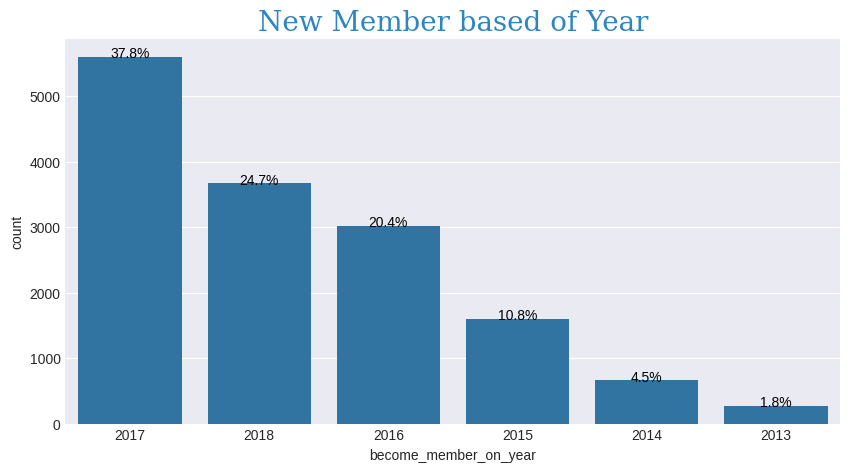

In [72]:
cat_order = profile['become_member_on_year'].value_counts().index
sns.countplot(data = profile, x = 'become_member_on_year', color=base_color, 
              order=cat_order)
plt.title('New Member based of Year', fontdict=font)

# add annotations
n_points = profile.shape[0]
cat_counts = profile['become_member_on_year'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'k')


> 2017 has the highest number of new members.

### New Member based of Month

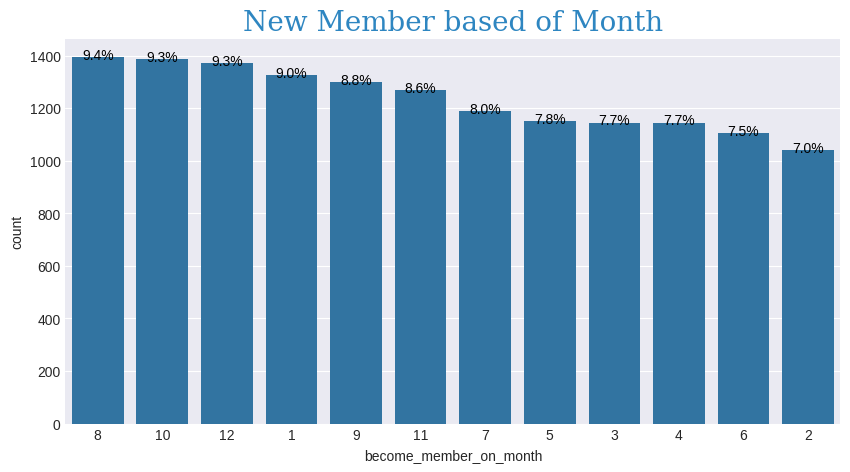

In [73]:
cat_order = profile['become_member_on_month'].value_counts().index
sns.countplot(data = profile, x = 'become_member_on_month', color=base_color, 
              order=cat_order)
plt.title('New Member based of Month', fontdict=font)

# add annotations
n_points = profile.shape[0]
cat_counts = profile['become_member_on_month'].value_counts()
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'k')


> We can notice grow in member based on month is almost equal

### New Memeber based on Year and Gender

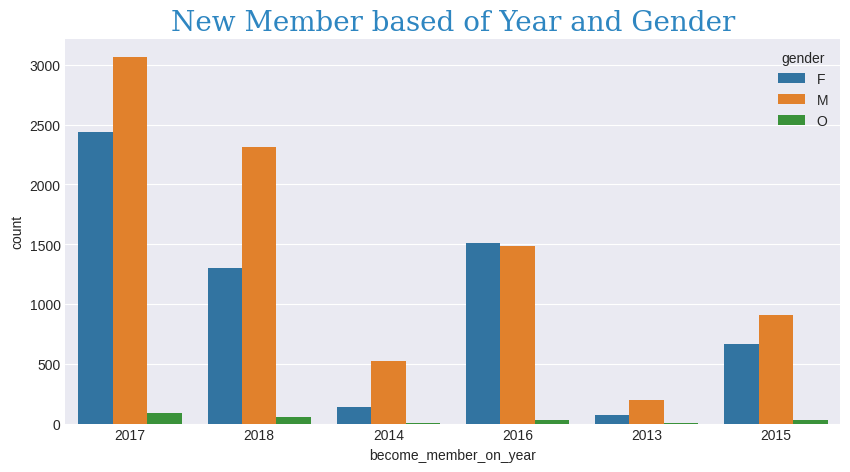

In [74]:
sns.countplot(data = profile, x = 'become_member_on_year', hue = 'gender')
plt.title('New Member based of Year and Gender', fontdict=font);

> We can notice that most new member are Male

### Income based on Gender

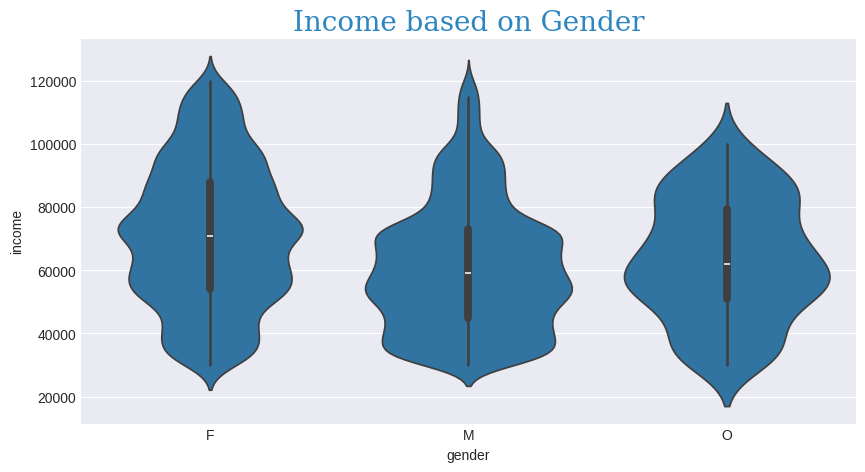

In [75]:
sns.violinplot(data = profile, y = 'income', x = 'gender');
plt.title('Income based on Gender', fontdict=font);

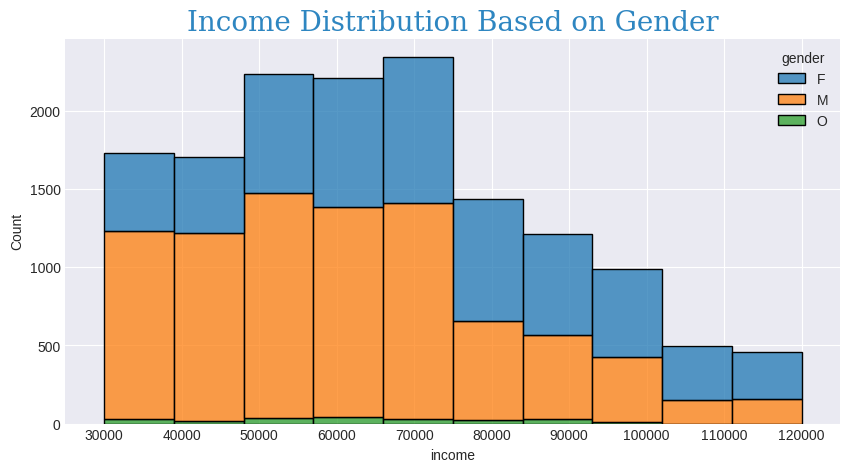

In [76]:
sns.histplot(data=profile, x="income", hue="gender", multiple="stack", 
            bins=10);

bin_edges = np.arange(0, profile['income'].max()+1, 10000)

plt.xticks(bin_edges)
plt.xlim(profile.income.min()-5000, profile.income.max()+5000)
plt.title('Income Distribution Based on Gender', fontdict=font);

> We can notice that the count Female gender is the highest one

## transcript

### Event Distribution

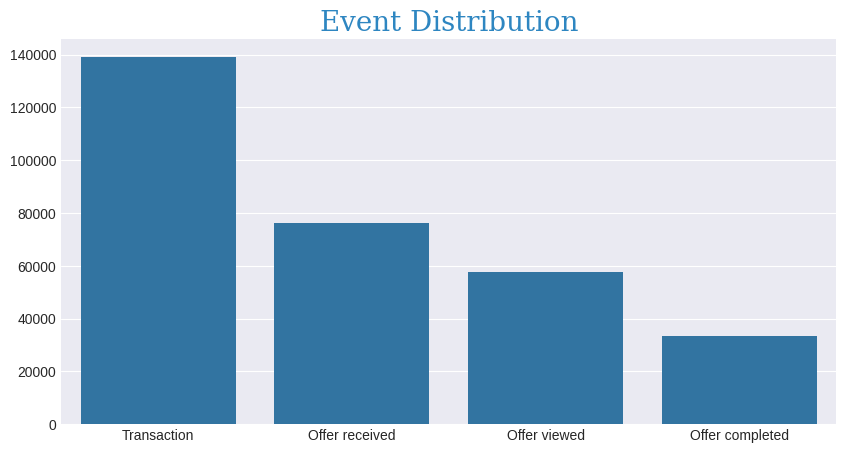

In [77]:
# create event list
x_value = ['Offer received','Offer viewed','Transaction','Offer completed']
y_value = [transcript.offer_received.sum(), transcript.offer_viewed.sum(),
    transcript.transaction.sum(), transcript.offer_completed.sum()]

# sort values
x_value = [x for _,x in sorted(zip(y_value,x_value), reverse=True)]
y_value.sort(reverse=True)

# show graph
sns.barplot(y = y_value, x = x_value , color=base_color);
plt.title('Event Distribution', fontdict=font);

> We can notice that most of offers are just received and viewed

### Offers Distribution

In [78]:
table = [
    ['Number of customer made transaction' ,
         transcript[transcript.transaction == 1].customer_id.count(),
    '100%'],
    
    
    ['Number of unique customers made transaction',
        transcript[transcript.transaction == 1].customer_id.nunique(),
    f"{round((16578/138953)*100, 2)}%"],
    
    
    ['Number of customers who recived offers', 
        transcript[transcript.transaction != 1].customer_id.count(),
    '100%'],
    
    
    ['Number of unique customers who recived offers',
        transcript[transcript.transaction != 1].customer_id.nunique(),
    f"{round((16994/167581)*100, 2)}%"]
        
        ]

header = ['Notice', 'Number', 'Percentage']

print(tabulate(table,header, tablefmt="simple"))

Notice                                           Number  Percentage
---------------------------------------------  --------  ------------
Number of customer made transaction              138953  100%
Number of unique customers made transaction       16578  11.93%
Number of customers who recived offers           167581  100%
Number of unique customers who recived offers     16994  10.14%


> We can notice that there are alot of repeated offers to the same customer
also we can notice that the customers who made transaction mostly are the same customers no new customer come

## Overall dataframe

### Distribution of Successful offers

/tmp/ipykernel_4294/975167303.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Failure', 'Success']);


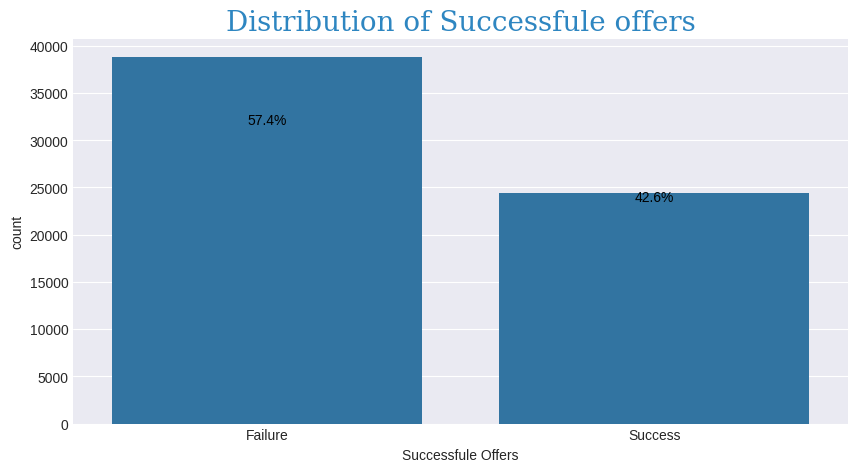

In [79]:
x = overall_df['successful_offer'].value_counts()
x.index = ['Failure', 'Success']

ax = sns.countplot(data = offer_customer, x = 'successful_offer', color = base_color)
plt.title('Distribution of Successfule offers', fontdict=font);
ax.set_xticklabels(['Failure', 'Success']);
ax.set_xlabel('Successfule Offers');

# add annotations
n_points = overall_df.shape[0]
cat_counts = x
locs, labels = plt.xticks() # get the current tick locations and labels

# loop through each pair of locations and labels
for loc, label in zip(locs, labels):

    # get the text property for the label to get the correct count
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)

    # print the annotation just below the top of the bar
    plt.text(loc, count-8, pct_string, ha = 'center', color = 'k')

> The Percentage of failure offers greater than success offers

### Distribution of Success based on offer type

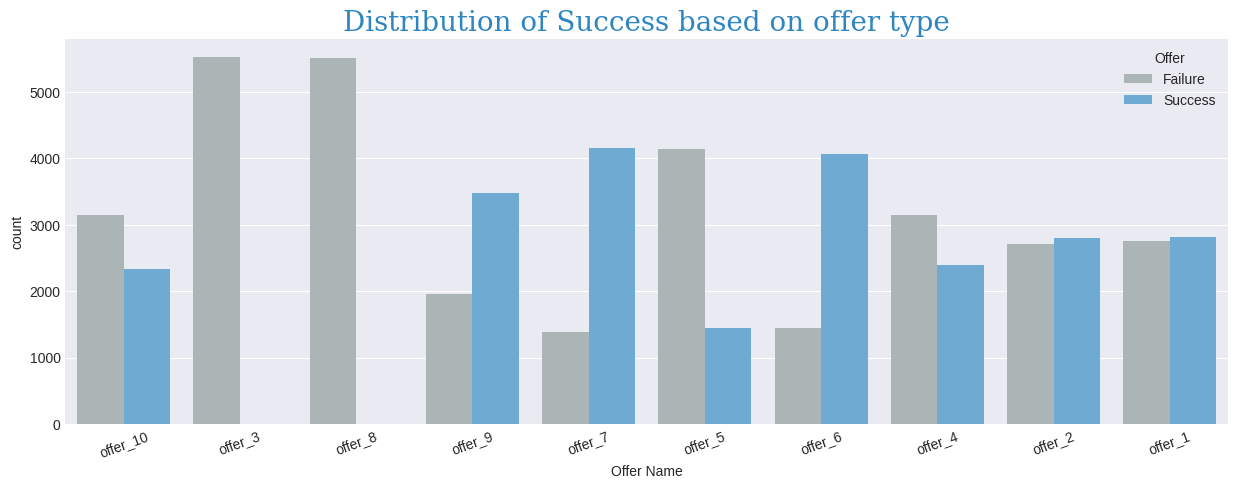

In [80]:
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = overall_df, x = 'offer_name', hue = 'successful_offer', 
                  palette=['#AAB7B8', '#5DADE2'])
ax.legend(['Failure', 'Success'], title = 'Offer', );
plt.title('Distribution of Success based on offer type', fontdict=font);
plt.xticks(rotation=20);
plt.xlabel('Offer Name');

> There are alot of offers need to review because is not success like offer_8. <br>
offer_7, offer_9, offer_6 have a successeful story

### Distribution of Offers based on Gender

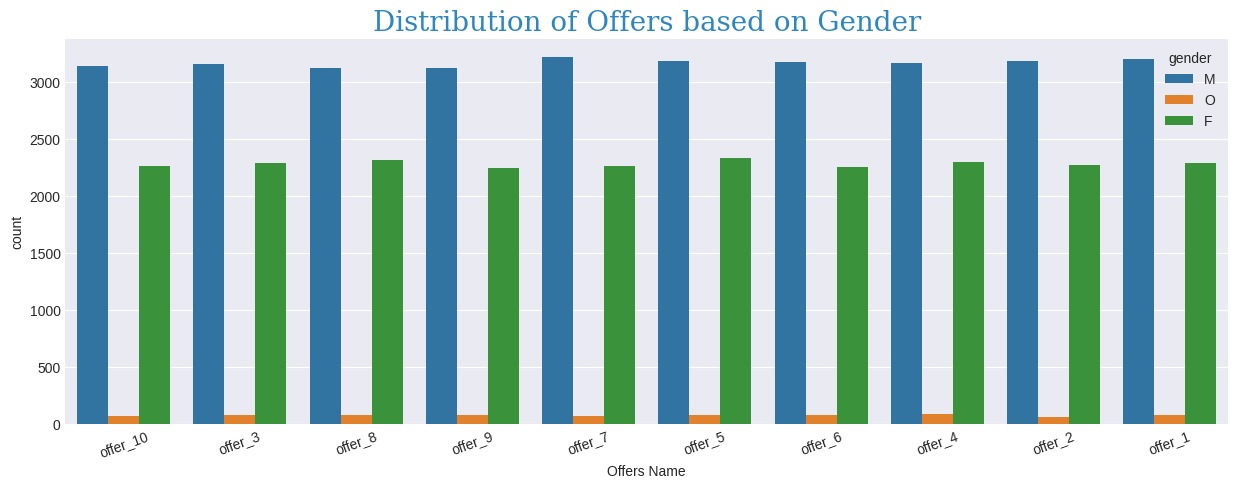

In [81]:
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = overall_df, x = 'offer_name', hue = 'gender', 
                   )
plt.title('Distribution of Offers based on Gender', fontdict=font);
plt.xticks(rotation=20);
plt.xlabel('Offers Name');

> We can notice that male have more offers then female and that is normal because the count of male is more than female

### Distribution of Success based on Gender

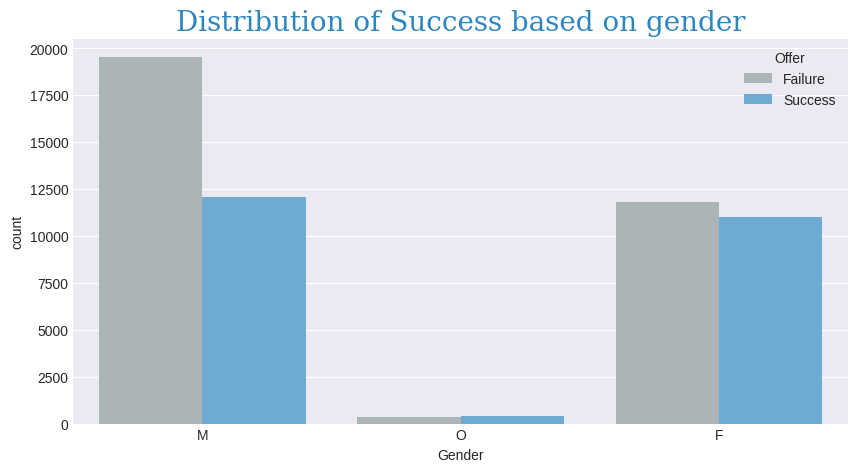

In [82]:
ax = sns.countplot(data = overall_df, x = 'gender', hue = 'successful_offer', 
                   palette=['#AAB7B8', '#5DADE2'])
ax.legend(['Failure', 'Success'], title = 'Offer', );
plt.title('Distribution of Success based on gender', fontdict=font);
plt.xlabel('Gender');

> The offers have more  failures with male  than female

### Distribution of of Success offers based on Gender

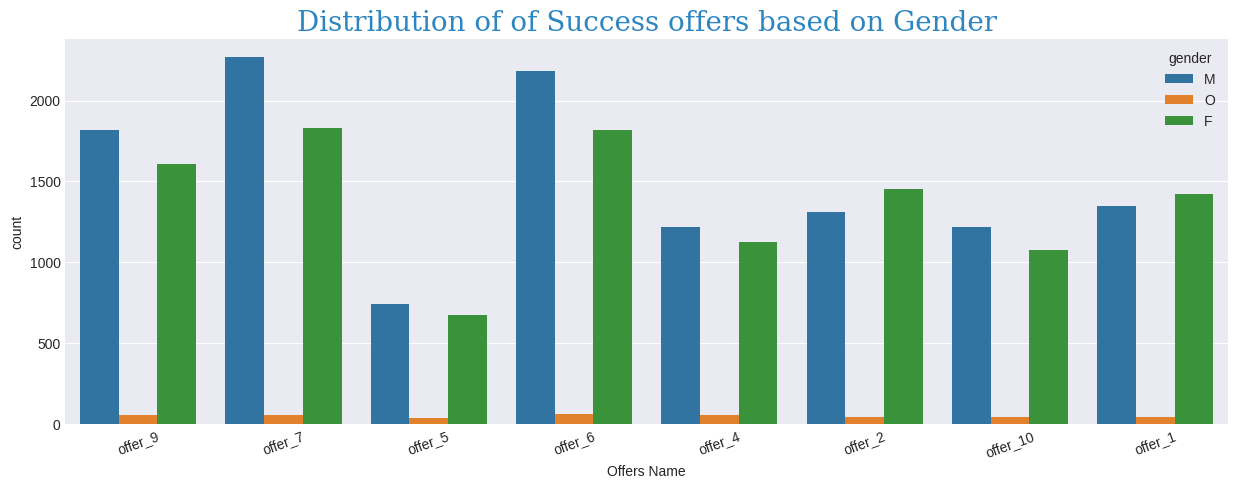

In [83]:
succes_offer = overall_df[overall_df.successful_offer == 1]
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = succes_offer, x = 'offer_name', hue = 'gender', 
                   )
plt.title('Distribution of of Success offers based on Gender', fontdict=font);
plt.xticks(rotation=20);
plt.xlabel('Offers Name');

> We can notice that the success offer in female is more than the other despite of the male in data set is more than female

### Income Distribution Based on Success

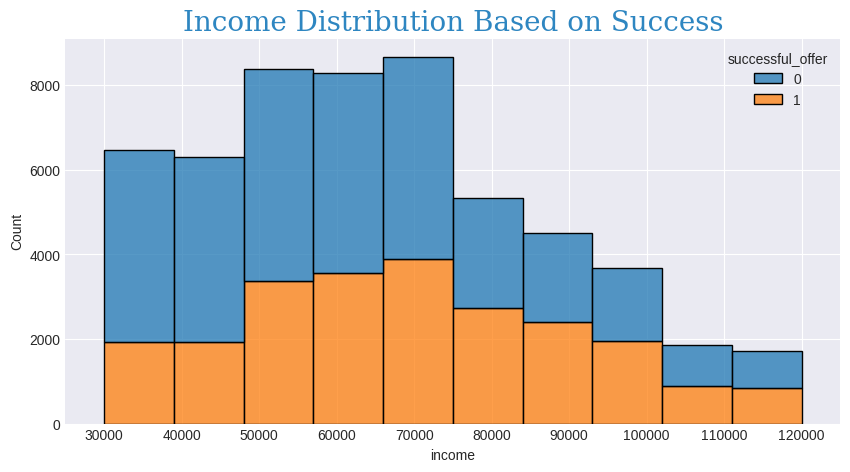

In [84]:
ax = sns.histplot(data=overall_df, x="income", hue="successful_offer", multiple="stack", 
            bins=10);

bin_edges = np.arange(0, profile['income'].max()+1, 10000)

plt.xticks(bin_edges)
plt.xlim(profile.income.min()-5000, profile.income.max()+5000)
plt.title('Income Distribution Based on Success', fontdict=font);

> We can notice that the income does not have any role in the reject offers

# Modeling

I will build a model that **predicts whether or not someone will respond to an offer**. 

In [85]:
overall_df = pd.read_csv('overall_df.csv')

## Data Preparation

In [86]:
overall_df.head()

,customer_id,offer_id,offer completed,offer received,offer viewed,successful_offer,reward,difficulty,duration,offer_type,...,gender,age,income,Female,Male,other,become_member_on_year,become_member_on_month,become_member_on_day,membership_length_in_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,0,2,10,7,discount,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,0,0,0,4,informational,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,0,0,3,informational,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,5,5,5,bogo,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,2,10,10,discount,...,M,33,72000.0,0.0,1.0,0.0,2017,4,21,2686


/tmp/ipykernel_4294/537491975.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette='coolwarm')


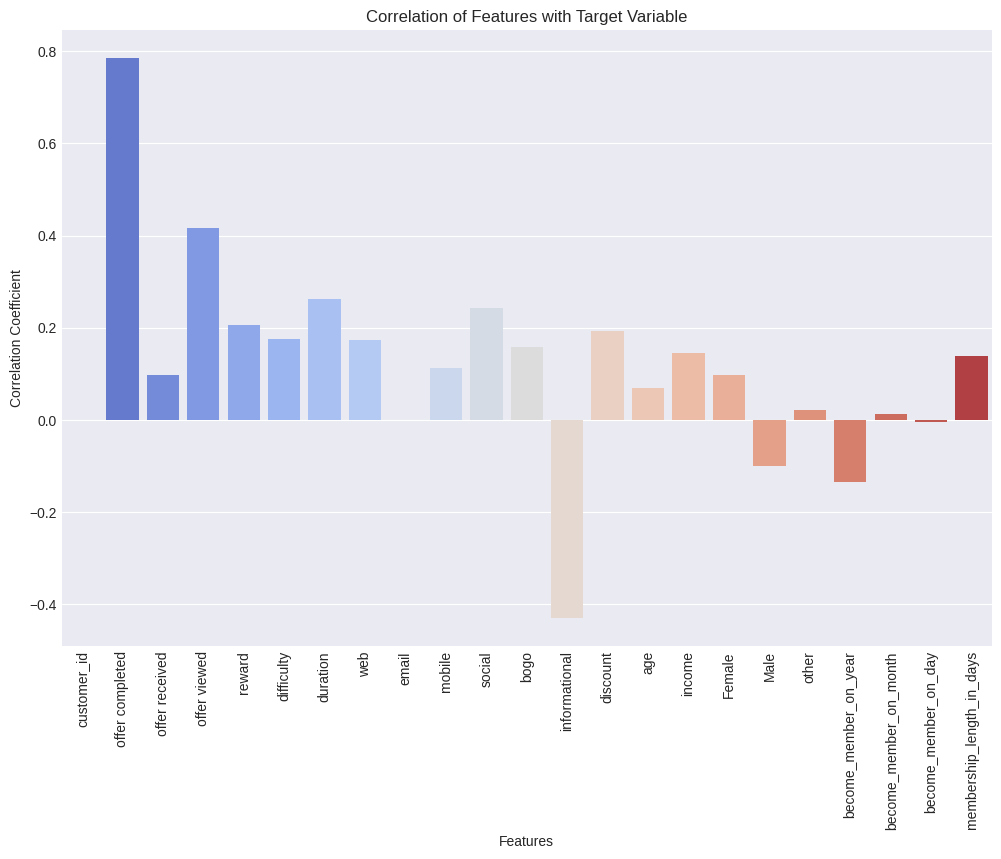

In [87]:
"""
Calculate the correlation of each feature with the target variable and plot the correlation values.

Parameters:
- overall_df: DataFrame
    The input DataFrame containing the data.
- target_variable: str
    The name of the column representing the target variable.

Returns:
None
"""
target_variable = 'successful_offer'  # Replace with your actual target variable column name

# Convert non-numeric columns to numeric, forcing errors to NaN
overall_df_numeric = overall_df.apply(pd.to_numeric, errors='coerce')

# Drop columns that cannot be converted to numeric
overall_df_numeric = overall_df_numeric.dropna(axis=1, how='all')

# Calculate the correlation of each feature with the target variable
corr_with_target = overall_df_numeric.corr()[target_variable].drop(target_variable)

# Plot the correlation with the target variable
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_with_target.index, y=corr_with_target.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlation of Features with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

In [88]:
# create x and y data by removing the categorical columns and id columns
X = overall_df.drop(['customer_id', 'offer_id', 
                     'offer_type', 'gender', 'offer_name', 'successful_offer', 
                    'offer received', 'social', 'discount', 'other', # remove C-1 binary variables
                     'become_member_on_year', 'become_member_on_month',
                     'become_member_on_day'], axis=1)
y = overall_df.loc[:, 'successful_offer']

#### Here I am trying to predict successful offers based on the following features

In [89]:
print(f"features: {X.columns}")

features: Index(['offer completed', 'offer viewed', 'reward', 'difficulty', 'duration',
       'web', 'email', 'mobile', 'bogo', 'informational', 'age', 'income',
       'Female', 'Male', 'membership_length_in_days'],
      dtype='object')


In [90]:
print(f"target_variable: {y.name}")

target_variable: successful_offer


## ML Pipline

In [91]:
X.iloc[:5]

,offer completed,offer viewed,reward,difficulty,duration,web,email,mobile,bogo,informational,age,income,Female,Male,membership_length_in_days
0,1,0,2,10,7,1,1,1,0,0,33,72000.0,0.0,1.0,2686
1,0,1,0,0,4,1,1,1,0,1,33,72000.0,0.0,1.0,2686
2,0,1,0,0,3,0,1,1,0,1,33,72000.0,0.0,1.0,2686
3,1,1,5,5,5,1,1,1,1,0,33,72000.0,0.0,1.0,2686
4,1,1,2,10,10,1,1,1,0,0,33,72000.0,0.0,1.0,2686


In [92]:
X.shape

(55222, 15)

### Train Test Split

In [93]:
X_train,X_test,y_train,y_test =\
    train_test_split(X, y, 
                     test_size=0.3, random_state=42)


In [94]:
overall_df.columns

Index(['customer_id', 'offer_id', 'offer completed', 'offer received',
       'offer viewed', 'successful_offer', 'reward', 'difficulty', 'duration',
       'offer_type', 'web', 'email', 'mobile', 'social', 'bogo',
       'informational', 'discount', 'offer_name', 'gender', 'age', 'income',
       'Female', 'Male', 'other', 'become_member_on_year',
       'become_member_on_month', 'become_member_on_day',
       'membership_length_in_days'],
      dtype='object')

### Hyper Parameter Tuning

In [95]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 2: Load the dataset
# Assuming the dataset is already loaded into a DataFrame named df
# df = pd.read_csv('path_to_your_dataset.csv')

# Step 3: Drop the specified columns
columns_to_drop = ['customer_id', 'offer_id', 'offer_type', 'gender', 'offer_name', 
                    'offer received', 'social', 'discount', 'other', 
                   'become_member_on_year', 'become_member_on_month', 'become_member_on_day']
overall_df = overall_df.drop(columns=columns_to_drop, errors='ignore')


# Step 4: Define features (X) and target (y)
# Replace 'target_column' with the actual name of the target column
X = overall_df.drop(columns=['successful_offer'])  # Drop the target column to get features
y = overall_df['successful_offer']  # Example target column

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Define the model and the hyperparameters to tune
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Step 7: Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Step 8: Fit the model and find the best parameters
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Step 9: Evaluate the model with the best parameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
#print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.9s
[CV] END m

### Create Transformers

In [96]:
from sklearn.ensemble import GradientBoostingClassifier


all_column = X.columns

# feature scaling
trf1 = ColumnTransformer([
    ('scale', MinMaxScaler(), all_column)
])

trf2 = LogisticRegression(solver='liblinear',random_state=42)


### Create Pipeline

In [97]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
])

#fit data
pipe.fit(X_train, y_train);

In [98]:
# check cross validation 
scoring = ['accuracy', 'precision', 'recall']

cross_val = cross_validate(pipe, X, y, cv=10, scoring=scoring)

### Check the Accurecy

In [99]:
# cross validation accurecy
table = []
header = ["Metrics", 'Scores']
table.append(['Accuracy', cross_val['test_accuracy'].tolist() if hasattr(cross_val['test_accuracy'], 'tolist') else cross_val['test_accuracy']])
table.append(['Precision', cross_val['test_precision'].tolist() if hasattr(cross_val['test_precision'], 'tolist') else cross_val['test_precision']])
table.append(['Recall', cross_val['test_recall'].tolist() if hasattr(cross_val['test_recall'], 'tolist') else cross_val['test_recall']])

print(tabulate(table, header, tablefmt="fancy_grid"))




╒═══════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Metrics   │ Scores                                                                                                                                                                                                   │
╞═══════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ Accuracy  │ [0.9920333152272316, 0.9931196813326091, 0.9934806229626947, 0.9927562477363274, 0.993118435349511, 0.9909453096704093, 0.9911264034770011, 0.9945671858022456, 0.9918507787033684, 0.9913074972835929]  │
├───────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [100]:
# pipeline accurecy
pipe.score(X_test, y_test)

0.9914891048469849

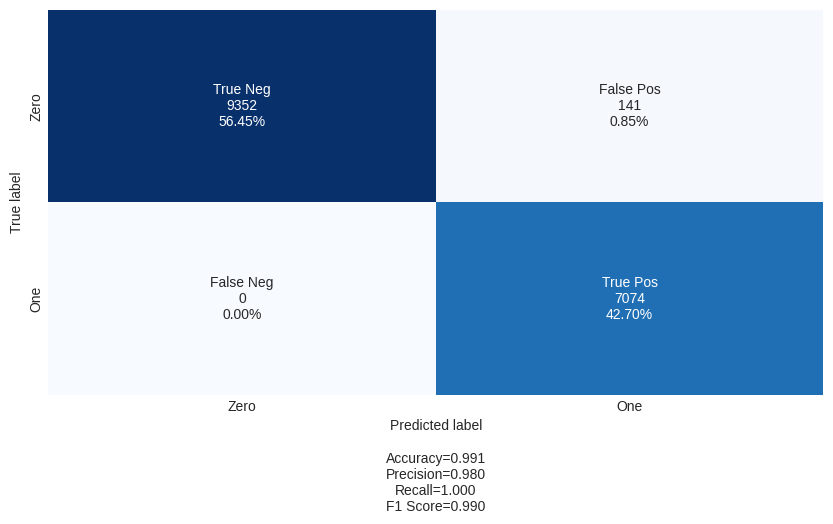

In [101]:
from confusion_matrix import make_confusion_matrix
y_pred = pipe.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

group_names =  ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

make_confusion_matrix(cf_matrix, group_names,categories, cbar=False)

In [102]:
if "membership_length_in_days" in overall_df.columns:
    print("The column 'membership_length_in_days' exists in the dataframe.")
else:
    print("The column 'membership_length_in_days' does not exist in the dataframe.")


The column 'membership_length_in_days' exists in the dataframe.


In [103]:
# Make sure that no two rows with the same features have different labels
if overall_df.duplicated(subset=X.columns).sum() == 0:
    print("There are no two rows with the same features and different labels.")
else:
    print("There are duplicate rows with the same features and different labels.")

There are duplicate rows with the same features and different labels.


In [104]:
# Duplicate rows with the same features but different labels will not help us in training the model.

print(f'Dataset Shape before removing rows with same features but different labels : {overall_df.shape}')
overall_df = overall_df.drop_duplicates(subset=X.columns, keep=False)
print(f'Dataset Shape after removing rows with same features but different labels : {overall_df.shape}')

Dataset Shape before removing rows with same features but different labels : (55222, 16)
Dataset Shape after removing rows with same features but different labels : (55212, 16)


▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬ check for dataset imbalance ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


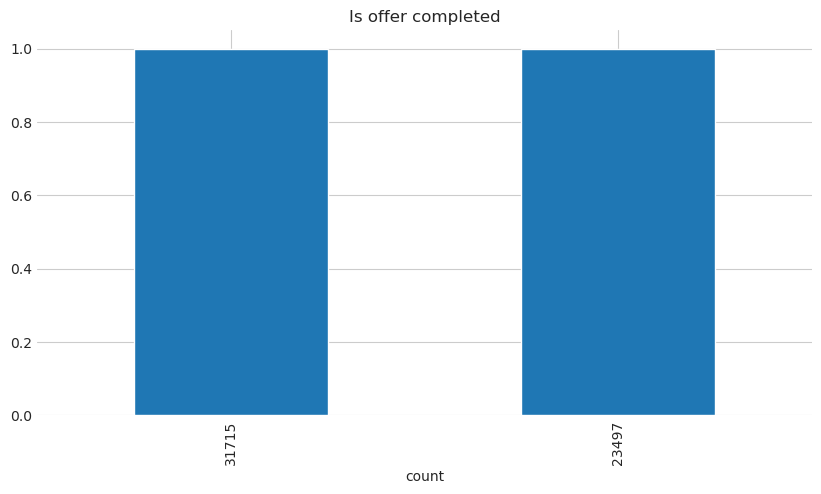

In [105]:
# check for dataset imbalance
p.print_comment('check for dataset imbalance')



sns.set_style('whitegrid')
overall_df.successful_offer.value_counts().value_counts().plot(kind='bar')
plt.title('Is offer completed')
plt.show()

**Note: From the above plot it is apparent that the dataset is balanced before splitting**



In [106]:
overall_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55212 entries, 0 to 55221
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   offer completed            55212 non-null  int64  
 1   offer viewed               55212 non-null  int64  
 2   successful_offer           55212 non-null  int64  
 3   reward                     55212 non-null  int64  
 4   difficulty                 55212 non-null  int64  
 5   duration                   55212 non-null  int64  
 6   web                        55212 non-null  int64  
 7   email                      55212 non-null  int64  
 8   mobile                     55212 non-null  int64  
 9   bogo                       55212 non-null  int64  
 10  informational              55212 non-null  int64  
 11  age                        55212 non-null  int64  
 12  income                     55212 non-null  float64
 13  Female                     55212 non-null  float64


In [107]:
X_train = X_train.reset_index(level=0, drop=True)
X_train.head(3)

,offer completed,offer viewed,reward,difficulty,duration,web,email,mobile,bogo,informational,age,income,Female,Male,membership_length_in_days
0,0,1,0,0,3,0,1,1,0,1,40,63000.0,1.0,0.0,2412
1,0,0,0,0,4,1,1,1,0,1,53,83000.0,0.0,1.0,2643
2,0,1,3,7,7,1,1,1,0,0,82,81000.0,0.0,1.0,2347


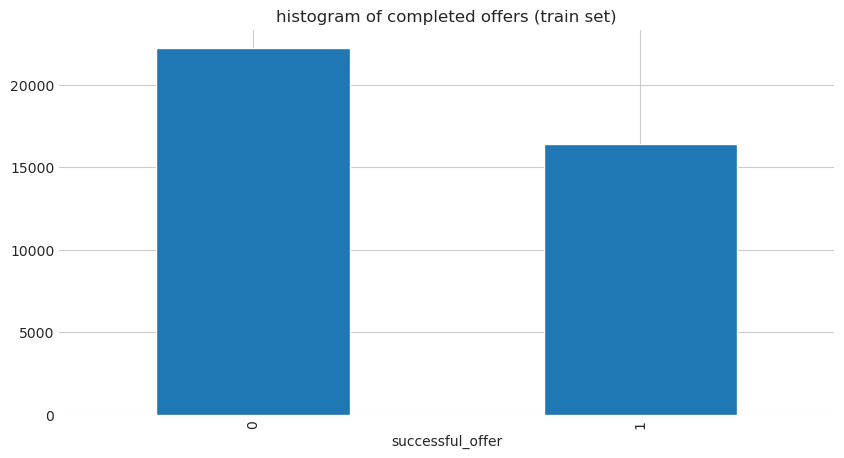

In [108]:
y_train = y_train.reset_index(level=0, drop=True)
y_train.value_counts().plot(kind='bar')
plt.title('histogram of completed offers (train set)')
plt.show()

In [109]:
X_test = X_test.reset_index(level=0, drop=True)
X_test.head(3)

,offer completed,offer viewed,reward,difficulty,duration,web,email,mobile,bogo,informational,age,income,Female,Male,membership_length_in_days
0,2,2,2,10,10,1,1,1,0,0,27,34000.0,0.0,1.0,2914
1,1,1,10,10,7,0,1,1,1,0,61,83000.0,1.0,0.0,3024
2,0,0,5,20,10,1,1,0,0,0,76,40000.0,0.0,1.0,2533


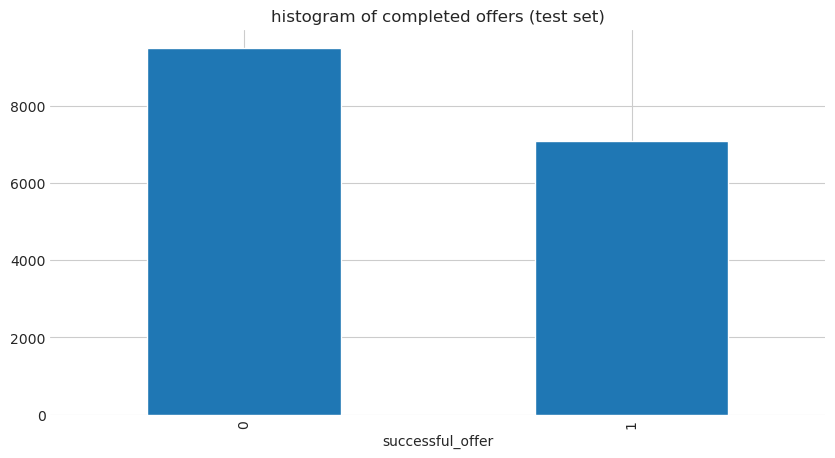

In [110]:
y_test = y_test.reset_index(level=0, drop=True)
y_test.value_counts().plot(kind='bar')
plt.title('histogram of completed offers (test set)')
plt.show()

## Experiment with gradient boost model

In [111]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling
trf1 = ColumnTransformer([
    ('scale', MinMaxScaler(), all_column)
])

# Gradient Boosting model
gb_model = Pipeline([
    ('transformer', trf1),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Logistic Regression model
lr_model = Pipeline([
    ('transformer', trf1),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Train and evaluate Gradient Boosting model
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
gb_precision = precision_score(y_test, gb_predictions)

# Train and evaluate Logistic Regression model
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_precision = precision_score(y_test, lr_predictions)

# Compare the precision scores
print(f"Gradient Boosting Precision: {gb_precision:.4f}")
print(f"Logistic Regression Precision: {lr_precision:.4f}")

Gradient Boosting Precision: 1.0000
Logistic Regression Precision: 0.9805


### Confusion matrix to evaluate accuracy

Gradient Boosting Training Precision: 1.0000
Gradient Boosting Training Recall: 1.0000
Gradient Boosting Training F1-Score: 1.0000
Gradient Boosting Training Accuracy: 1.0000
Gradient Boosting Test Precision: 1.0000
Gradient Boosting Test Recall: 1.0000
Gradient Boosting Test F1-Score: 1.0000
Gradient Boosting Test Accuracy: 1.0000
Confusion Matrix (Test Data):
[[9493    0]
 [   0 7074]]


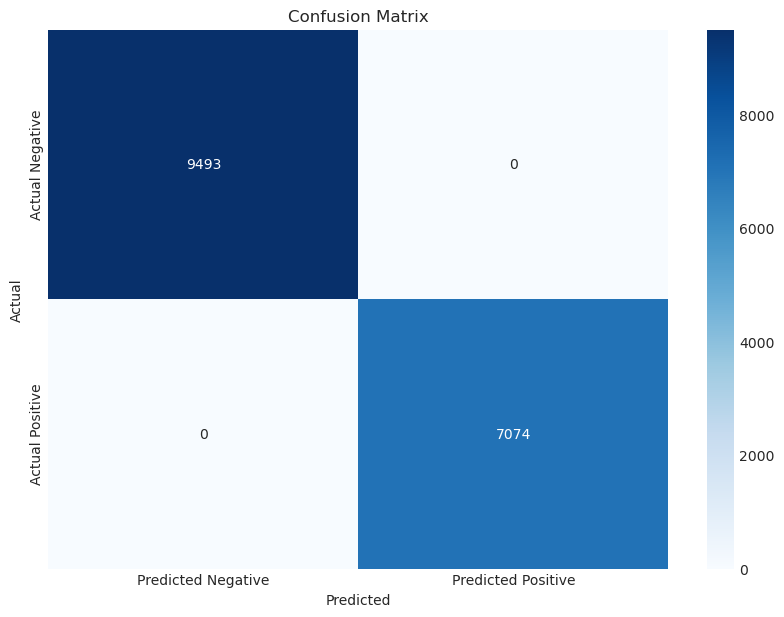

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, confusion_matrix, accuracy_score, precision_score

# Evaluate on training data
gb_train_predictions = gb_model.predict(X_train)
gb_train_precision = precision_score(y_train, gb_train_predictions)
gb_train_recall = recall_score(y_train, gb_train_predictions)
gb_train_f1 = f1_score(y_train, gb_train_predictions)
gb_train_accuracy = accuracy_score(y_train, gb_train_predictions)

# Evaluate on test data
gb_test_precision = precision_score(y_test, gb_predictions)
gb_test_recall = recall_score(y_test, gb_predictions)
gb_test_f1 = f1_score(y_test, gb_predictions)
gb_test_accuracy = accuracy_score(y_test, gb_predictions)

# Print training and test performance
print(f"Gradient Boosting Training Precision: {gb_train_precision:.4f}")
print(f"Gradient Boosting Training Recall: {gb_train_recall:.4f}")
print(f"Gradient Boosting Training F1-Score: {gb_train_f1:.4f}")
print(f"Gradient Boosting Training Accuracy: {gb_train_accuracy:.4f}")

print(f"Gradient Boosting Test Precision: {gb_test_precision:.4f}")
print(f"Gradient Boosting Test Recall: {gb_test_recall:.4f}")
print(f"Gradient Boosting Test F1-Score: {gb_test_f1:.4f}")
print(f"Gradient Boosting Test Accuracy: {gb_test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, gb_predictions)
print("Confusion Matrix (Test Data):")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()